In [2]:
import pandas as pd
import numpy as np

import os
import matplotlib.pyplot as plt

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 불러오기

In [ ]:
os.path.abspath(os.curdir)

'/content'

In [3]:
DATA_PATH =  "drive/MyDrive/PSID/20250323/[01]Data/"
datas = os.listdir(DATA_PATH)
print('COREMOF_O2_15_minus1e3_based.csv')
O2_15bar = pd.read_csv(os.path.join(DATA_PATH , 'COREMOF_O2_15_minus1e3_based.csv')).reset_index(drop = True).drop("Unnamed: 0", axis = 1)
O2_15bar  = O2_15bar[['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
       'NASA_m2_cm3', 'NASA_m2_g', 'AV_VF', 'AV_cm3_g', 'NAV_cm3_g', 'Has_OMS',
       '0.001bar_GCMC',  'Uptake']]
O2_15bar

COREMOF_O2_15_minus1e3_based.csv


,Adsorbent,LCD,PLD,LFPD,cm3_g,ASA_m2_cm3,ASA_m2_g,NASA_m2_cm3,NASA_m2_g,AV_VF,AV_cm3_g,NAV_cm3_g,Has_OMS,0.001bar_GCMC,Uptake
0,ABAYIO_clean,11.39486,4.32260,11.27409,0.949126,1428.730,1505.310,409.4940,431.4440,0.6636,0.699170,0.0,0,0.000228,2.198162
1,ABAYOU_clean,11.27344,4.51080,11.27344,0.979267,1463.420,1494.400,419.0620,427.9350,0.6638,0.677854,0.0,0,0.000229,2.278860
2,ABETIN_clean,9.47418,7.83744,9.45292,0.597233,2275.990,3810.890,0.0000,0.0000,0.7302,1.222640,0.0,0,0.000295,4.284861
3,ABEXIQ_clean,4.80529,4.06893,4.80529,1.787600,954.695,534.065,11.1491,6.2369,0.4776,0.267174,0.0,1,0.000075,0.778792
4,ABIYIV_clean,4.33176,3.82431,4.32093,1.346610,564.007,418.836,0.0000,0.0000,0.4458,0.331055,0.0,0,0.000140,1.007825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5755,ZURQOS_clean,4.62363,3.68876,4.61478,1.306180,1284.420,983.341,0.0000,0.0000,0.5260,0.402701,0.0,1,0.000311,2.494882
5756,ZURROT_clean,4.90807,3.92111,4.90807,1.077740,1554.640,1442.500,0.0000,0.0000,0.6110,0.566926,0.0,1,0.000203,2.239383
5757,ZUSBIA_clean,4.68848,3.56399,4.68848,1.219810,1104.240,905.252,0.0000,0.0000,0.5638,0.462202,0.0,1,0.000370,2.695531
5758,ZUSNOS_clean,13.06588,6.72307,12.14953,0.801750,2346.370,2926.560,0.0000,0.0000,0.7098,0.885314,0.0,1,0.000490,4.578689


## 액티브 러닝 몬테카를로 드랍아웃
* 10개씩 추가 샘플링해가며 5%부터 학습

In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch 모델 정의
class DropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DropoutMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.model(x)

# Monte Carlo Dropout 예측 함수
def mc_dropout_predict(model, X, n_simulations):
    model.train()  # 드롭아웃 활성화를 위해 train 모드 유지
    predictions = []
    with torch.no_grad():  # 가중치 업데이트 방지
        for _ in range(n_simulations):
            predictions.append(model(X).detach().numpy())

    predictions = np.array(predictions)
    mean_prediction = predictions.mean(axis=0)
    uncertainty = predictions.std(axis=0)
    return mean_prediction, uncertainty

# 데이터 준비
data = pd.read_csv("drive/MyDrive/PSID/20250323/[01]Data/COREMOF_O2_15_minus1e3_based.csv").reset_index(drop=True).drop("Unnamed: 0", axis=1)
data = data[['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
              'AV_VF', 'AV_cm3_g',  'Has_OMS',
             '0.001bar_GCMC', 'Uptake']]
# 'NASA_m2_cm3', 'NASA_m2_g', 'NAV_cm3_g' 제거

X = data.drop(['Adsorbent', 'Uptake'], axis=1)
y = data['Uptake']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train 데이터를 Initial (5%)와 Remaining (95%)으로 랜덤 분리
initial_size = int(0.05 * len(X_train))
indices = np.random.permutation(len(X_train))  # 데이터셋 인덱스를 랜덤으로 섞음
initial_indices = indices[:initial_size]  # 상위 5% 인덱스 선택
remaining_indices = indices[initial_size:]  # 나머지 인덱스 선택

X_initial = X_train.iloc[initial_indices]
y_initial = y_train.iloc[initial_indices]
X_remaining = pd.DataFrame(X_train.iloc[remaining_indices], columns=X_train.columns)
y_remaining = y_train.iloc[remaining_indices]
def create_dataloader(X, y, batch_size=32, shuffle=True):
    # y를 numpy 배열로 변환 (필요 시)
    if isinstance(y, pd.Series):
        y = y.to_numpy()
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

input_dim = X_train.shape[1]
hidden_dim = 64
# StandardScaler를 초기 데이터에 대해 피팅
scaler = StandardScaler()
X_initial_scaled = scaler.fit_transform(X_initial)
X_test_scaled = scaler.transform(X_test)

# 남은 데이터를 그대로 둠 (추후 transform 적용)
X_remaining = pd.DataFrame(X_train.iloc[remaining_indices], columns=X_train.columns)
y_remaining = y_train.iloc[remaining_indices].to_numpy()

# 초기 데이터 로더 생성
train_loader = create_dataloader(X_initial_scaled, y_initial)
test_loader = create_dataloader(X_test_scaled, y_test.to_numpy(), shuffle=False)

# 모델 초기화
model = DropoutMLP(input_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 초기 학습
epochs = 50
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

# 액티브 러닝 설정
iterations = 100
samples_per_iteration = 10
performance_log = []

# 초기 성능 평가
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
mean_prediction, _ = mc_dropout_predict(model, X_test_tensor, n_simulations=20)
mse = mean_squared_error(y_test, mean_prediction)
r2 = r2_score(y_test, mean_prediction)
performance_log.append((mse, r2))
print(f"Initial Test MSE: {mse}, R2: {r2}")

# 반복 학습
for iteration in range(iterations):
    # Monte Carlo Dropout 예측
    _, uncertainties = mc_dropout_predict(model, torch.tensor(scaler.transform(X_remaining), dtype=torch.float32), n_simulations=20)
    uncertainties = uncertainties.flatten()

    # 가장 불확실성이 높은 샘플 선택
    most_uncertain_indices = np.argsort(uncertainties)[-samples_per_iteration:]
    sampled_X = X_remaining.iloc[most_uncertain_indices].values
    sampled_y = y_remaining[most_uncertain_indices]

    # 선택된 샘플 추가
    X_initial = np.vstack([X_initial, sampled_X])
    y_initial = np.hstack([y_initial, sampled_y])

    # 남은 데이터에서 샘플 제거
    X_remaining = X_remaining.drop(X_remaining.index[most_uncertain_indices]).reset_index(drop=True)
    y_remaining = np.delete(y_remaining, most_uncertain_indices, axis=0)

    # 새 데이터 스케일링 및 로더 생성
    X_initial_scaled = scaler.transform(X_initial)
    train_loader = create_dataloader(X_initial_scaled, y_initial)

    # 모델 학습
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # Test 성능 평가
    mean_prediction, _ = mc_dropout_predict(model, X_test_tensor, n_simulations=20)
    mse = mean_squared_error(y_test, mean_prediction)
    r2 = r2_score(y_test, mean_prediction)
    performance_log.append((mse, r2))
    print(f"Iteration {iteration + 1}/{iterations} - Test MSE: {mse}, R2: {r2}")

# 최종 성능 기록
print("Performance log:", performance_log)
first_log = performance_log


Initial Test MSE: 12601.805359640131, R2: -7717.004189824283


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 1/100 - Test MSE: 6.174313692339899, R2: -2.781472383265695


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 2/100 - Test MSE: 1.3171533224340126, R2: 0.19330646910761462


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 3/100 - Test MSE: 0.5636220204702287, R2: 0.6548084190065069


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 4/100 - Test MSE: 1.1173816358933797, R2: 0.31565709028661826


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 5/100 - Test MSE: 0.3138296426292657, R2: 0.8077943256875617


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 6/100 - Test MSE: 0.301063003639746, R2: 0.8156132826067553


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 7/100 - Test MSE: 0.6801884826902251, R2: 0.5834170256202644


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 8/100 - Test MSE: 0.2966960620499642, R2: 0.8182878258586768


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 9/100 - Test MSE: 0.2785505459657093, R2: 0.8294010882181584


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 10/100 - Test MSE: 0.27547743889879933, R2: 0.8312832195907117


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 11/100 - Test MSE: 0.2732560216004875, R2: 0.8326437316385036


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 12/100 - Test MSE: 0.28417029242403086, R2: 0.8259592617914475


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 13/100 - Test MSE: 0.26014832961840234, R2: 0.84067156723424


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 14/100 - Test MSE: 0.25388229447443866, R2: 0.8445092146279685


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 15/100 - Test MSE: 0.27088694548413206, R2: 0.8340946776633171


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 16/100 - Test MSE: 0.2327018890012269, R2: 0.857481201856717


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 17/100 - Test MSE: 0.23506643102877187, R2: 0.8560330327448487


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 18/100 - Test MSE: 0.2318696291472948, R2: 0.857990921286303


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 19/100 - Test MSE: 0.23003723020982914, R2: 0.8591131781592812


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 20/100 - Test MSE: 0.23185028002364622, R2: 0.858002771700837


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 21/100 - Test MSE: 0.21210947992800602, R2: 0.870093069360615


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 22/100 - Test MSE: 0.20858008658454055, R2: 0.8722546542950758


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 23/100 - Test MSE: 0.1881328580247356, R2: 0.8847776056652258


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 24/100 - Test MSE: 0.19873577598709088, R2: 0.8782838245820875


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 25/100 - Test MSE: 0.18844243768776683, R2: 0.884588002900529


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 26/100 - Test MSE: 0.18427525703861186, R2: 0.8871402021126307


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 27/100 - Test MSE: 0.18588934127461712, R2: 0.8861516525722517


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 28/100 - Test MSE: 0.18577797639043256, R2: 0.8862198582474075


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 29/100 - Test MSE: 0.1863654997082906, R2: 0.8858600282627791


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 30/100 - Test MSE: 0.16463977178080208, R2: 0.8991659994618239


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 31/100 - Test MSE: 0.17199420844078775, R2: 0.8946617580983318


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 32/100 - Test MSE: 0.17186521013835387, R2: 0.89474076340037


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 33/100 - Test MSE: 0.1763494365209081, R2: 0.891994388811891


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 34/100 - Test MSE: 0.17149890221245956, R2: 0.8949651095179408


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 35/100 - Test MSE: 0.16747524338009204, R2: 0.8974294084687955


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 36/100 - Test MSE: 0.16553611881296465, R2: 0.8986170296950059


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 37/100 - Test MSE: 0.17949459801783074, R2: 0.8900681275407348


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 38/100 - Test MSE: 0.16142741084963896, R2: 0.9011334171784432


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 39/100 - Test MSE: 0.5206007413877942, R2: 0.6811568986674648


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 40/100 - Test MSE: 0.1656134792376742, R2: 0.8985696501279521


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 41/100 - Test MSE: 0.16695524484822943, R2: 0.8977478827455425


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 42/100 - Test MSE: 0.15633341551814187, R2: 0.9042532461386139


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 43/100 - Test MSE: 0.16800613244980336, R2: 0.8971042642575155


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 44/100 - Test MSE: 0.16363189576185924, R2: 0.8997832754088034


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 45/100 - Test MSE: 0.16668939229150284, R2: 0.8979107047451


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 46/100 - Test MSE: 0.16071720829927877, R2: 0.9015683823364402


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 47/100 - Test MSE: 0.16410572828832196, R2: 0.8994930756064619


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 48/100 - Test MSE: 0.1700686170072511, R2: 0.8958410909262712


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 49/100 - Test MSE: 0.15792640852075898, R2: 0.9032776139718185


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 50/100 - Test MSE: 0.19326955245431326, R2: 0.8816316255458773


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 51/100 - Test MSE: 0.16409942409121053, R2: 0.8994969366262389


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 52/100 - Test MSE: 0.16851863190270278, R2: 0.8967903828086377


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 53/100 - Test MSE: 0.15935069233089563, R2: 0.9024053081314712


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 54/100 - Test MSE: 0.1647079457596093, R2: 0.899124246154337


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 55/100 - Test MSE: 0.167296429873519, R2: 0.8975389232052592


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 56/100 - Test MSE: 0.17386819158295158, R2: 0.8935140328851491


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 57/100 - Test MSE: 0.1666980444234943, R2: 0.8979054057272962


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 58/100 - Test MSE: 0.15423099499452936, R2: 0.9055408783426457


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 59/100 - Test MSE: 0.16492726872877045, R2: 0.8989899213059044


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 60/100 - Test MSE: 0.1662237532972744, R2: 0.8981958864000961


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 61/100 - Test MSE: 0.1603742608945732, R2: 0.9017784212499823


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 62/100 - Test MSE: 0.14697515641062708, R2: 0.9099847330914741


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 63/100 - Test MSE: 0.15345950294953, R2: 0.9060133803902326


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 64/100 - Test MSE: 0.14987821552658526, R2: 0.9082067479710221


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 65/100 - Test MSE: 0.1886242981526223, R2: 0.8844766220475748


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 66/100 - Test MSE: 0.15662636521251402, R2: 0.9040738284358288


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 67/100 - Test MSE: 0.170548839747369, R2: 0.8955469774231258


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 68/100 - Test MSE: 0.16958351968299995, R2: 0.8961381898794921


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 69/100 - Test MSE: 0.15285061171403314, R2: 0.9063862972043395


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 70/100 - Test MSE: 0.16986516666968995, R2: 0.8959656945455865


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 71/100 - Test MSE: 0.16934268608514597, R2: 0.896285688961111


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 72/100 - Test MSE: 0.1690410237183988, R2: 0.8964704427597948


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 73/100 - Test MSE: 0.1808646477877558, R2: 0.8892290374609583


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 74/100 - Test MSE: 0.1688822987349511, R2: 0.8965676542348429


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 75/100 - Test MSE: 0.17690948597752953, R2: 0.8916513852557055


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 76/100 - Test MSE: 0.1790279714479344, R2: 0.890353914038682


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 77/100 - Test MSE: 0.1730692795859342, R2: 0.8940033283443559


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 78/100 - Test MSE: 0.16372422977353387, R2: 0.8997267252345522


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 79/100 - Test MSE: 0.19902969697090483, R2: 0.8781038120108874


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 80/100 - Test MSE: 0.1620622798587196, R2: 0.9007445902181597


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 81/100 - Test MSE: 0.17435166449915085, R2: 0.8932179288043129


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 82/100 - Test MSE: 0.15414011993768867, R2: 0.9055965349767098


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 83/100 - Test MSE: 0.1576418082514427, R2: 0.9034519180503471


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 84/100 - Test MSE: 0.16134578870483823, R2: 0.901183406845604


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 85/100 - Test MSE: 0.1628830789095964, R2: 0.9002418899833219


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 86/100 - Test MSE: 0.1908754914726991, R2: 0.8830978736079185


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 87/100 - Test MSE: 0.15496692042609547, R2: 0.9050901591478853


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 88/100 - Test MSE: 0.19876619506821777, R2: 0.8782651943470626


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 89/100 - Test MSE: 0.2736424242088233, R2: 0.8324070784872301


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 90/100 - Test MSE: 0.16999014428477166, R2: 0.8958891517226093


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 91/100 - Test MSE: 0.17071716643390175, R2: 0.8954438853633104


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 92/100 - Test MSE: 0.16501328900695214, R2: 0.8989372379920085


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 93/100 - Test MSE: 0.16013280267694247, R2: 0.901926302881396


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 94/100 - Test MSE: 0.1599728305465894, R2: 0.9020242781743865


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 95/100 - Test MSE: 0.1600101299437521, R2: 0.9020014340742466


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 96/100 - Test MSE: 0.1773209945917789, R2: 0.8913993558743364


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 97/100 - Test MSE: 0.15510891361156792, R2: 0.9050031951003439


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 98/100 - Test MSE: 0.16753093759852236, R2: 0.8973952984187727


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 99/100 - Test MSE: 0.14718871106343034, R2: 0.9098539410614391


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100/100 - Test MSE: 0.1683682110708406, R2: 0.8968825083872685
Performance log: [(12601.805359640131, -7717.004189824283), (6.174313692339899, -2.781472383265695), (1.3171533224340126, 0.19330646910761462), (0.5636220204702287, 0.6548084190065069), (1.1173816358933797, 0.31565709028661826), (0.3138296426292657, 0.8077943256875617), (0.301063003639746, 0.8156132826067553), (0.6801884826902251, 0.5834170256202644), (0.2966960620499642, 0.8182878258586768), (0.2785505459657093, 0.8294010882181584), (0.27547743889879933, 0.8312832195907117), (0.2732560216004875, 0.8326437316385036), (0.28417029242403086, 0.8259592617914475), (0.26014832961840234, 0.84067156723424), (0.25388229447443866, 0.8445092146279685), (0.27088694548413206, 0.8340946776633171), (0.2327018890012269, 0.857481201856717), (0.23506643102877187, 0.8560330327448487), (0.2318696291472948, 0.857990921286303), (0.23003723020982914, 0.8591131781592812), (0.23185028002364622, 0.858002771700837), (0.21210947992800602, 0.

## 랜덤하게 샘플링해서 추가

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch 모델 정의
class DropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DropoutMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.model(x)

# 데이터 준비
data = pd.read_csv("drive/MyDrive/PSID/20250323/[01]Data/COREMOF_O2_15_minus1e3_based.csv").reset_index(drop=True).drop("Unnamed: 0", axis=1)
data = data[['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
              'AV_VF', 'AV_cm3_g',  'Has_OMS',
             '0.001bar_GCMC', 'Uptake']]
X = data.drop(['Adsorbent', 'Uptake'], axis=1)
y = data['Uptake']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Train 데이터를 Initial (5%)와 Remaining (95%)으로 랜덤 분리
initial_size = int(0.05 * len(X_train))
indices = np.random.permutation(len(X_train))
initial_indices = indices[:initial_size]
remaining_indices = indices[initial_size:]

X_initial = X_train.iloc[initial_indices]
y_initial = y_train.iloc[initial_indices].to_numpy()

# 스탠다드 스케일러 적용
scaler = StandardScaler()
X_initial_scaled = scaler.fit_transform(X_initial)
X_test_scaled = scaler.transform(X_test)
X_remaining = pd.DataFrame(X_train.iloc[remaining_indices], columns=X_train.columns).reset_index(drop =True)
y_remaining = y_train.iloc[remaining_indices].reset_index(drop =True)

def create_dataloader(X, y, batch_size=32, shuffle=True):
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = create_dataloader(X_initial_scaled, y_initial)
test_loader = create_dataloader(X_test_scaled, y_test.to_numpy(), shuffle=False)

# 모델 초기화
input_dim = X_train.shape[1]
hidden_dim = 64
model = DropoutMLP(input_dim, hidden_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 초기 모델 학습
epochs = 50
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

# 랜덤 샘플링 설정
iterations = 100
samples_per_iteration = 10
performance_log = []

X_remaining_tensor = torch.tensor(X_remaining.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# 초기 Test 성능 평가
mean_prediction, _ = mc_dropout_predict(model, X_test_tensor, n_simulations=20)
mse = mean_squared_error(y_test, mean_prediction)
r2 = r2_score(y_test, mean_prediction)
performance_log.append((mse, r2))
print(f"Initial Test MSE: {mse}, R2: {r2}")

for iteration in range(iterations):
    # 랜덤으로 샘플 선택
    sample_indices = np.random.choice(X_remaining.index, size=samples_per_iteration, replace=False)
    sample_indices = X_remaining.index[sample_indices]  # 현재 인덱스 동기화
    sampled_X = X_remaining.iloc[sample_indices].values
    sampled_y = y_remaining.iloc[sample_indices].to_numpy()

    # 선택된 샘플을 Training Set에 추가
    X_initial = np.vstack([X_initial, sampled_X])
    y_initial = np.hstack([y_initial, sampled_y])
    X_initial_scaled = scaler.transform(X_initial)
    # 남은 데이터에서 선택된 샘플 제거
    X_remaining = X_remaining.drop(sample_indices).reset_index(drop=True)  # 인덱스 초기화
    y_remaining = y_remaining.drop(sample_indices).reset_index(drop=True)  # 인덱스 초기화


    # 새 학습 데이터로 DataLoader 생성
    train_loader = create_dataloader(X_initial_scaled, y_initial)

    # 모델 재학습
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # Test 성능 평가
    mean_prediction, _ = mc_dropout_predict(model, X_test_tensor, n_simulations=20)
    mse = mean_squared_error(y_test, mean_prediction)
    r2 = r2_score(y_test, mean_prediction)
    performance_log.append((mse, r2))
    print(f"Iteration {iteration + 1}/{iterations} - Test MSE: {mse}, R2: {r2}")

# 성능 기록 출력
print("Performance log:", performance_log)
second_log = performance_log


Initial Test MSE: 0.740499572996318, R2: 0.5464793619767603


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 1/100 - Test MSE: 0.7278211720209, R2: 0.5542442773246785


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 2/100 - Test MSE: 0.7072537934928818, R2: 0.566840814814564


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 3/100 - Test MSE: 0.7010630522715009, R2: 0.5706323482751395


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 4/100 - Test MSE: 0.7130058349271924, R2: 0.5633179640306412


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 5/100 - Test MSE: 0.7222102831391647, R2: 0.5576806789085789


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 6/100 - Test MSE: 0.7011194794665158, R2: 0.57059778931195


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 7/100 - Test MSE: 0.7268799163726035, R2: 0.5548207514750025


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 8/100 - Test MSE: 0.6967429228403641, R2: 0.5732782213146395


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 9/100 - Test MSE: 0.689555356537625, R2: 0.5776802625504807


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 10/100 - Test MSE: 0.7098015255794389, R2: 0.5652804505367937


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 11/100 - Test MSE: 0.6857508710807886, R2: 0.5800103282718597


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 12/100 - Test MSE: 0.7160609841906417, R2: 0.5614468309554264


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 13/100 - Test MSE: 0.6982042014422866, R2: 0.5723832579304041


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 14/100 - Test MSE: 0.7125937738172148, R2: 0.5635703317892684


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 15/100 - Test MSE: 0.7314572201507069, R2: 0.5520173714251373


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 16/100 - Test MSE: 0.6934931293042691, R2: 0.5752685647147981


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 17/100 - Test MSE: 0.7065663377628747, R2: 0.5672618486309968


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 18/100 - Test MSE: 0.6960342145701708, R2: 0.5737122712973691


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 19/100 - Test MSE: 0.7245030162084644, R2: 0.5562764893555743


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 20/100 - Test MSE: 0.680457266682573, R2: 0.5832524082563315


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 21/100 - Test MSE: 0.6871491427641256, R2: 0.5791539536173937


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 22/100 - Test MSE: 0.7085808133764036, R2: 0.5660280784860215


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 23/100 - Test MSE: 0.6904735463551929, R2: 0.5771179151203465


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 24/100 - Test MSE: 0.6852655938063044, R2: 0.5803075374360078


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 25/100 - Test MSE: 0.6840503004436032, R2: 0.5810518466042189


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 26/100 - Test MSE: 0.6765039715709347, R2: 0.5856736127873075


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 27/100 - Test MSE: 0.6742275640508645, R2: 0.5870678037207684


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 28/100 - Test MSE: 0.6662008273040505, R2: 0.5919837967927559


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 29/100 - Test MSE: 0.6559491060876569, R2: 0.5982624866346451


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 30/100 - Test MSE: 0.6670971854933677, R2: 0.5914348201927133


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 31/100 - Test MSE: 0.6614862495864144, R2: 0.5948712505773148


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 32/100 - Test MSE: 0.6788367127454091, R2: 0.5842449201798157


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 33/100 - Test MSE: 0.6670192849822532, R2: 0.5914825305369071


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 34/100 - Test MSE: 0.6707702204160427, R2: 0.5891852616482394


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 35/100 - Test MSE: 0.6747408183580164, R2: 0.5867534599596966


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 36/100 - Test MSE: 0.6546087342318819, R2: 0.5990834004087877


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 37/100 - Test MSE: 0.6527594246894923, R2: 0.6002160142199927


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 38/100 - Test MSE: 0.6585619686494945, R2: 0.5966622330500053


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 39/100 - Test MSE: 0.6689611859516754, R2: 0.5902932088968328


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 40/100 - Test MSE: 0.6503755409704062, R2: 0.6016760291945842


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 41/100 - Test MSE: 0.6707135370689934, R2: 0.5892199774923216


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 42/100 - Test MSE: 0.6723998649213422, R2: 0.5881871821857436


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 43/100 - Test MSE: 0.6657587215339438, R2: 0.5922545654714214


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 44/100 - Test MSE: 0.6570912388214906, R2: 0.5975629848590268


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 45/100 - Test MSE: 0.6613201936304116, R2: 0.5949729519230823


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 46/100 - Test MSE: 0.6527210675091162, R2: 0.6002395061618537


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 47/100 - Test MSE: 0.6661141505751478, R2: 0.5920368821513804


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 48/100 - Test MSE: 0.6742829394994581, R2: 0.587033888902053


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 49/100 - Test MSE: 0.6501841974340071, R2: 0.6017932179761498


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 50/100 - Test MSE: 0.6394022904190736, R2: 0.6083966213092995


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 51/100 - Test MSE: 0.642169804288499, R2: 0.6067016511816041


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 52/100 - Test MSE: 0.6357585834030223, R2: 0.6106282179110407


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 53/100 - Test MSE: 0.635709177452754, R2: 0.6106584766970076


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 54/100 - Test MSE: 0.6576526756374306, R2: 0.5972191316114894


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 55/100 - Test MSE: 0.6445482701415072, R2: 0.6052449543913441


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 56/100 - Test MSE: 0.6350811668822848, R2: 0.6110431031910541


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 57/100 - Test MSE: 0.6210244857954156, R2: 0.6196521493100284


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 58/100 - Test MSE: 0.6143149768346249, R2: 0.6237614032457299


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 59/100 - Test MSE: 0.616968898164505, R2: 0.6221360031257536


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 60/100 - Test MSE: 0.6333425973374669, R2: 0.6121078940403224


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 61/100 - Test MSE: 0.6357459520593564, R2: 0.610635954006033


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 62/100 - Test MSE: 0.6250587084586043, R2: 0.6171813805170985


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 63/100 - Test MSE: 0.6162762187888117, R2: 0.6225602361757996


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 64/100 - Test MSE: 0.6339079460563458, R2: 0.6117616449389838


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 65/100 - Test MSE: 0.6328994274151297, R2: 0.6123793144614278


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 66/100 - Test MSE: 0.6131612456444279, R2: 0.6244680085221763


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 67/100 - Test MSE: 0.6302633488770596, R2: 0.613993786723211


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 68/100 - Test MSE: 0.6147714739063371, R2: 0.6234818205818522


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 69/100 - Test MSE: 0.6137677106494464, R2: 0.6240965776584125


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 70/100 - Test MSE: 0.6100562808127988, R2: 0.6263696512547741


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 71/100 - Test MSE: 0.6200739195152472, R2: 0.6202343257778973


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 72/100 - Test MSE: 0.6088719264115272, R2: 0.6270950117860933


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 73/100 - Test MSE: 0.6126994695007686, R2: 0.624750824365606


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 74/100 - Test MSE: 0.615508058111655, R2: 0.6230306979196176


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 75/100 - Test MSE: 0.6117245563282897, R2: 0.6253479121427277


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 76/100 - Test MSE: 0.6145393756462585, R2: 0.6236239696860968


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 77/100 - Test MSE: 0.6143964085242332, R2: 0.6237115302232824


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 78/100 - Test MSE: 0.6005811580098768, R2: 0.632172711642158


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 79/100 - Test MSE: 0.6143185835185052, R2: 0.6237591943240315


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 80/100 - Test MSE: 0.6126825228413969, R2: 0.6247612033854608


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 81/100 - Test MSE: 0.6163997462591458, R2: 0.6224845814972524


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 82/100 - Test MSE: 0.6018393872593201, R2: 0.6314021062930179


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 83/100 - Test MSE: 0.6101302165172565, R2: 0.626324369165383


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 84/100 - Test MSE: 0.615160711430729, R2: 0.6232434311798293


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 85/100 - Test MSE: 0.6159320811052348, R2: 0.622771004078328


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 86/100 - Test MSE: 0.6048323682132022, R2: 0.629569048339583


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 87/100 - Test MSE: 0.6005334031580761, R2: 0.6322019592091346


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 88/100 - Test MSE: 0.6051237523935602, R2: 0.6293905894393961


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 89/100 - Test MSE: 0.6146938575877408, R2: 0.6235293568716955


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 90/100 - Test MSE: 0.6040163120884573, R2: 0.6300688437585857


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 91/100 - Test MSE: 0.6148694425925505, R2: 0.6234218194384376


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 92/100 - Test MSE: 0.6006411268978084, R2: 0.6321359835611327


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 93/100 - Test MSE: 0.6019164877158083, R2: 0.6313548859440892


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 94/100 - Test MSE: 0.5979662332933848, R2: 0.6337742281980792


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 95/100 - Test MSE: 0.6086665634348277, R2: 0.627220786805574


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 96/100 - Test MSE: 0.6153471186441117, R2: 0.6231292656604579


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 97/100 - Test MSE: 0.6078514275764996, R2: 0.6277200186053289


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 98/100 - Test MSE: 0.6034607372052769, R2: 0.6304091068521486


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 99/100 - Test MSE: 0.5931329709658194, R2: 0.6367343706403789


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Iteration 100/100 - Test MSE: 0.599747787580973, R2: 0.632683111245897
Performance log: [(0.740499572996318, 0.5464793619767603), (0.7278211720209, 0.5542442773246785), (0.7072537934928818, 0.566840814814564), (0.7010630522715009, 0.5706323482751395), (0.7130058349271924, 0.5633179640306412), (0.7222102831391647, 0.5576806789085789), (0.7011194794665158, 0.57059778931195), (0.7268799163726035, 0.5548207514750025), (0.6967429228403641, 0.5732782213146395), (0.689555356537625, 0.5776802625504807), (0.7098015255794389, 0.5652804505367937), (0.6857508710807886, 0.5800103282718597), (0.7160609841906417, 0.5614468309554264), (0.6982042014422866, 0.5723832579304041), (0.7125937738172148, 0.5635703317892684), (0.7314572201507069, 0.5520173714251373), (0.6934931293042691, 0.5752685647147981), (0.7065663377628747, 0.5672618486309968), (0.6960342145701708, 0.5737122712973691), (0.7245030162084644, 0.5562764893555743), (0.680457266682573, 0.5832524082563315), (0.6871491427641256, 0.579153953617393

## 랜덤 샘플링이면서 매번 아예 새로운 모델을 학습시키는 코드

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch 모델 정의
class DropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DropoutMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.model(x)

# 데이터 준비
data = pd.read_csv("drive/MyDrive/PSID/20250323/[01]Data/COREMOF_O2_15_minus1e3_based.csv").reset_index(drop=True).drop("Unnamed: 0", axis=1)
data = data[['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
              'AV_VF', 'AV_cm3_g',  'Has_OMS',
             '0.001bar_GCMC', 'Uptake']]
X = data.drop(['Adsorbent', 'Uptake'], axis=1)
y = data['Uptake']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train 데이터를 Initial (5%)와 Remaining (95%)으로 랜덤 분리
initial_size = int(0.05 * len(X_train))
indices = np.random.permutation(len(X_train))
initial_indices = indices[:initial_size]
remaining_indices = indices[initial_size:]

X_initial = X_train.iloc[initial_indices]
y_initial = y_train.iloc[initial_indices].to_numpy()

# 스탠다드 스케일러 적용
scaler = StandardScaler()
X_initial_scaled = scaler.fit_transform(X_initial)
X_test_scaled = scaler.transform(X_test)
X_remaining = pd.DataFrame(X_train.iloc[remaining_indices], columns=X_train.columns).reset_index(drop=True)
y_remaining = y_train.iloc[remaining_indices].reset_index(drop=True)

def create_dataloader(X, y, batch_size=32, shuffle=True):
    dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = create_dataloader(X_initial_scaled, y_initial)
test_loader = create_dataloader(X_test_scaled, y_test.to_numpy(), shuffle=False)

# 모델 초기화
input_dim = X_train.shape[1]
hidden_dim = 64
criterion = nn.MSELoss()

# 랜덤 샘플링 설정
iterations = 100
samples_per_iteration = 10
performance_log = []

for iteration in range(iterations):
    # 랜덤으로 샘플 선택
    sample_indices = np.random.choice(X_remaining.index, size=samples_per_iteration, replace=False)
    sampled_X = X_remaining.iloc[sample_indices].values
    sampled_y = y_remaining.iloc[sample_indices].to_numpy()

    # 선택된 샘플을 Training Set에 추가
    X_initial = np.vstack([X_initial, sampled_X])
    y_initial = np.hstack([y_initial, sampled_y])

    # 남은 데이터에서 선택된 샘플 제거
    X_remaining = X_remaining.drop(sample_indices).reset_index(drop=True)
    y_remaining = y_remaining.drop(sample_indices).reset_index(drop=True)

    # 새 데이터 스케일링
    scaler = StandardScaler()
    X_initial_scaled = scaler.fit_transform(X_initial)
    X_test_scaled = scaler.transform(X_test)
    train_loader = create_dataloader(X_initial_scaled, y_initial)

    # 새로운 모델 생성
    model = DropoutMLP(input_dim, hidden_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 모델 학습
    epochs = 50
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # Test 성능 평가
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).squeeze().numpy()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    performance_log.append((mse, r2))

    print(f"Iteration {iteration + 1}/{iterations} - Samples: {len(y_initial)}, Test MSE: {mse:.4f}, R2: {r2:.4f}")

# 성능 기록 출력
print("Performance log:")
for entry in performance_log:
    print(f"MSE: {entry[0]:.4f}, R2: {entry[1]:.4f}")
third_log = performance_log

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 1/100 - Samples: 240, Test MSE: 12.9072, R2: -6.9050


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 2/100 - Samples: 250, Test MSE: 18.1748, R2: -10.1312


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 3/100 - Samples: 260, Test MSE: 15.2710, R2: -8.3528


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 4/100 - Samples: 270, Test MSE: 25.4399, R2: -14.5807


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 5/100 - Samples: 280, Test MSE: 11.8028, R2: -6.2286


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 6/100 - Samples: 290, Test MSE: 17.5890, R2: -9.7725


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 7/100 - Samples: 300, Test MSE: 13.4846, R2: -7.2587


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 8/100 - Samples: 310, Test MSE: 10.1039, R2: -5.1881


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 9/100 - Samples: 320, Test MSE: 4.6611, R2: -1.8547


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 10/100 - Samples: 330, Test MSE: 9.9289, R2: -5.0810


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 11/100 - Samples: 340, Test MSE: 13.7112, R2: -7.3974


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 12/100 - Samples: 350, Test MSE: 12.8703, R2: -6.8824


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 13/100 - Samples: 360, Test MSE: 20.1032, R2: -11.3122


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 14/100 - Samples: 370, Test MSE: 14.6794, R2: -7.9904


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 15/100 - Samples: 380, Test MSE: 18.7722, R2: -10.4971


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 16/100 - Samples: 390, Test MSE: 15.8771, R2: -8.7240


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 17/100 - Samples: 400, Test MSE: 21.8151, R2: -12.3607


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 18/100 - Samples: 410, Test MSE: 13.3383, R2: -7.1691


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 19/100 - Samples: 420, Test MSE: 14.0923, R2: -7.6309


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 20/100 - Samples: 430, Test MSE: 16.5911, R2: -9.1612


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 21/100 - Samples: 440, Test MSE: 7.3197, R2: -3.4830


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 22/100 - Samples: 450, Test MSE: 6.4014, R2: -2.9205


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 23/100 - Samples: 460, Test MSE: 3.2552, R2: -0.9937


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 24/100 - Samples: 470, Test MSE: 2.4640, R2: -0.5091


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 25/100 - Samples: 480, Test MSE: 5.1924, R2: -2.1801


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 26/100 - Samples: 490, Test MSE: 2.8954, R2: -0.7733


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 27/100 - Samples: 500, Test MSE: 2.7393, R2: -0.6777


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 28/100 - Samples: 510, Test MSE: 3.7182, R2: -1.2772


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 29/100 - Samples: 520, Test MSE: 2.9355, R2: -0.7979


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 30/100 - Samples: 530, Test MSE: 4.7302, R2: -1.8970


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 31/100 - Samples: 540, Test MSE: 2.3880, R2: -0.4626


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 32/100 - Samples: 550, Test MSE: 3.4808, R2: -1.1318


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 33/100 - Samples: 560, Test MSE: 4.3881, R2: -1.6875


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 34/100 - Samples: 570, Test MSE: 3.5355, R2: -1.1653


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 35/100 - Samples: 580, Test MSE: 1.8314, R2: -0.1217


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 36/100 - Samples: 590, Test MSE: 2.1243, R2: -0.3010


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 37/100 - Samples: 600, Test MSE: 1.9612, R2: -0.2012


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 38/100 - Samples: 610, Test MSE: 0.8568, R2: 0.4752


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 39/100 - Samples: 620, Test MSE: 2.5971, R2: -0.5906


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 40/100 - Samples: 630, Test MSE: 2.0070, R2: -0.2292


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 41/100 - Samples: 640, Test MSE: 2.5994, R2: -0.5920


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 42/100 - Samples: 650, Test MSE: 3.1633, R2: -0.9374


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 43/100 - Samples: 660, Test MSE: 1.7589, R2: -0.0773


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 44/100 - Samples: 670, Test MSE: 2.3677, R2: -0.4501


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 45/100 - Samples: 680, Test MSE: 1.8616, R2: -0.1401


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 46/100 - Samples: 690, Test MSE: 1.6791, R2: -0.0284


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 47/100 - Samples: 700, Test MSE: 2.1072, R2: -0.2905


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 48/100 - Samples: 710, Test MSE: 6.8628, R2: -3.2032


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 49/100 - Samples: 720, Test MSE: 2.2574, R2: -0.3826


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 50/100 - Samples: 730, Test MSE: 3.3774, R2: -1.0685


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 51/100 - Samples: 740, Test MSE: 4.9619, R2: -2.0389


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 52/100 - Samples: 750, Test MSE: 1.8445, R2: -0.1297


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 53/100 - Samples: 760, Test MSE: 3.0246, R2: -0.8524


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 54/100 - Samples: 770, Test MSE: 2.2159, R2: -0.3571


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 55/100 - Samples: 780, Test MSE: 1.2062, R2: 0.2613


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 56/100 - Samples: 790, Test MSE: 3.6203, R2: -1.2172


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 57/100 - Samples: 800, Test MSE: 3.0682, R2: -0.8791


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 58/100 - Samples: 810, Test MSE: 1.2756, R2: 0.2187


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 59/100 - Samples: 820, Test MSE: 4.3555, R2: -1.6675


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 60/100 - Samples: 830, Test MSE: 0.8827, R2: 0.4594


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 61/100 - Samples: 840, Test MSE: 1.1808, R2: 0.2768


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 62/100 - Samples: 850, Test MSE: 0.8267, R2: 0.4937


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 63/100 - Samples: 860, Test MSE: 1.8802, R2: -0.1515


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 64/100 - Samples: 870, Test MSE: 2.0175, R2: -0.2356


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 65/100 - Samples: 880, Test MSE: 1.1621, R2: 0.2883


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 66/100 - Samples: 890, Test MSE: 0.8983, R2: 0.4499


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 67/100 - Samples: 900, Test MSE: 1.0890, R2: 0.3330


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 68/100 - Samples: 910, Test MSE: 1.8962, R2: -0.1613


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 69/100 - Samples: 920, Test MSE: 0.4434, R2: 0.7284


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 70/100 - Samples: 930, Test MSE: 2.8234, R2: -0.7292


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 71/100 - Samples: 940, Test MSE: 4.1179, R2: -1.5220


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 72/100 - Samples: 950, Test MSE: 1.9190, R2: -0.1753


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 73/100 - Samples: 960, Test MSE: 1.1453, R2: 0.2985


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 74/100 - Samples: 970, Test MSE: 1.9426, R2: -0.1898


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 75/100 - Samples: 980, Test MSE: 5.6842, R2: -2.4813


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 76/100 - Samples: 990, Test MSE: 1.4682, R2: 0.1008


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 77/100 - Samples: 1000, Test MSE: 0.7650, R2: 0.5314


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 78/100 - Samples: 1010, Test MSE: 4.9143, R2: -2.0098


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 79/100 - Samples: 1020, Test MSE: 1.0981, R2: 0.3275


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 80/100 - Samples: 1030, Test MSE: 2.7663, R2: -0.6942


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 81/100 - Samples: 1040, Test MSE: 0.5469, R2: 0.6650


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 82/100 - Samples: 1050, Test MSE: 1.9975, R2: -0.2234


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 83/100 - Samples: 1060, Test MSE: 7.1820, R2: -3.3986


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 84/100 - Samples: 1070, Test MSE: 0.4020, R2: 0.7538


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 85/100 - Samples: 1080, Test MSE: 5.0495, R2: -2.0926


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 86/100 - Samples: 1090, Test MSE: 0.7157, R2: 0.5617


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 87/100 - Samples: 1100, Test MSE: 0.4376, R2: 0.7320


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 88/100 - Samples: 1110, Test MSE: 7.3007, R2: -3.4713


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 89/100 - Samples: 1120, Test MSE: 0.4193, R2: 0.7432


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 90/100 - Samples: 1130, Test MSE: 0.5568, R2: 0.6590


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 91/100 - Samples: 1140, Test MSE: 1.7522, R2: -0.0731


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 92/100 - Samples: 1150, Test MSE: 0.9156, R2: 0.4392


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 93/100 - Samples: 1160, Test MSE: 0.8644, R2: 0.4706


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 94/100 - Samples: 1170, Test MSE: 4.7987, R2: -1.9390


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 95/100 - Samples: 1180, Test MSE: 0.5137, R2: 0.6854


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 96/100 - Samples: 1190, Test MSE: 0.9796, R2: 0.4000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 97/100 - Samples: 1200, Test MSE: 4.9018, R2: -2.0021


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 98/100 - Samples: 1210, Test MSE: 0.3915, R2: 0.7602


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 99/100 - Samples: 1220, Test MSE: 4.5291, R2: -1.7739


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Iteration 100/100 - Samples: 1230, Test MSE: 1.4021, R2: 0.1413
Performance log:
MSE: 12.9072, R2: -6.9050
MSE: 18.1748, R2: -10.1312
MSE: 15.2710, R2: -8.3528
MSE: 25.4399, R2: -14.5807
MSE: 11.8028, R2: -6.2286
MSE: 17.5890, R2: -9.7725
MSE: 13.4846, R2: -7.2587
MSE: 10.1039, R2: -5.1881
MSE: 4.6611, R2: -1.8547
MSE: 9.9289, R2: -5.0810
MSE: 13.7112, R2: -7.3974
MSE: 12.8703, R2: -6.8824
MSE: 20.1032, R2: -11.3122
MSE: 14.6794, R2: -7.9904
MSE: 18.7722, R2: -10.4971
MSE: 15.8771, R2: -8.7240
MSE: 21.8151, R2: -12.3607
MSE: 13.3383, R2: -7.1691
MSE: 14.0923, R2: -7.6309
MSE: 16.5911, R2: -9.1612
MSE: 7.3197, R2: -3.4830
MSE: 6.4014, R2: -2.9205
MSE: 3.2552, R2: -0.9937
MSE: 2.4640, R2: -0.5091
MSE: 5.1924, R2: -2.1801
MSE: 2.8954, R2: -0.7733
MSE: 2.7393, R2: -0.6777
MSE: 3.7182, R2: -1.2772
MSE: 2.9355, R2: -0.7979
MSE: 4.7302, R2: -1.8970
MSE: 2.3880, R2: -0.4626
MSE: 3.4808, R2: -1.1318
MSE: 4.3881, R2: -1.6875
MSE: 3.5355, R2: -1.1653
MSE: 1.8314, R2: -0.1217
MSE: 2.1243, R2: -0.3

## 랜덤하게 아예 모델 재학습 시키는 경우 높은 샘플링 비율 포인트 찍어서 성능보기

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# PyTorch 모델 정의
class DropoutMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DropoutMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.2),  # 드롭아웃 적용
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.model(x)

# 데이터 준비
data = pd.read_csv("drive/MyDrive/PSID/20250323/[01]Data/COREMOF_O2_15_minus1e3_based.csv").reset_index(drop=True).drop("Unnamed: 0", axis=1)
data = data[['Adsorbent', 'LCD', 'PLD', 'LFPD', 'cm3_g', 'ASA_m2_cm3', 'ASA_m2_g',
              'AV_VF', 'AV_cm3_g',  'Has_OMS',
             '0.001bar_GCMC', 'Uptake']]
X = data.drop(['Adsorbent', 'Uptake'], axis=1)
y = data['Uptake']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


for i in np.arange(0.3, 1.05, 0.05):
    # Train 데이터를 Initial (5%)와 Remaining (95%)으로 랜덤 분리
    initial_size = int( i* len(X_train))
    indices = np.random.permutation(len(X_train))
    initial_indices = indices[:initial_size]
    remaining_indices = indices[initial_size:]

    X_initial = X_train.iloc[initial_indices]
    y_initial = y_train.iloc[initial_indices].to_numpy()

    # 스탠다드 스케일러 적용
    scaler = StandardScaler()
    X_initial_scaled = scaler.fit_transform(X_initial)
    X_test_scaled = scaler.transform(X_test)
    X_remaining = pd.DataFrame(X_train.iloc[remaining_indices], columns=X_train.columns).reset_index(drop =True)
    y_remaining = y_train.iloc[remaining_indices].reset_index(drop =True)

    def create_dataloader(X, y, batch_size=32, shuffle=True):
        dataset = TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    train_loader = create_dataloader(X_initial_scaled, y_initial)
    test_loader = create_dataloader(X_test_scaled, y_test.to_numpy(), shuffle=False)

    # 모델 초기화
    input_dim = X_train.shape[1]
    hidden_dim = 64
    model = DropoutMLP(input_dim, hidden_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 초기 모델 학습
    epochs = 50
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

    # 랜덤 샘플링 설정
    iterations = 100
    samples_per_iteration = 10
    performance_log = []

    X_remaining_tensor = torch.tensor(X_remaining.values, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_tensor).squeeze().numpy()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    performance_log.append((mse, r2))

    print(f"Sample_Fraction {i} - Samples: {len(y_initial)}, Test MSE: {mse:.4f}, R2: {r2:.4f}")
train_fractions = np.arange(0.3, 1.05, 0.05)
fourth_log = performance_log

Sample_Fraction 0.3 - Samples: 1382, Test MSE: 0.6297, R2: 0.6144
Sample_Fraction 0.35 - Samples: 1612, Test MSE: 16.7461, R2: -9.2562
Sample_Fraction 0.39999999999999997 - Samples: 1843, Test MSE: 0.6639, R2: 0.5934
Sample_Fraction 0.44999999999999996 - Samples: 2073, Test MSE: 15.2687, R2: -8.3514
Sample_Fraction 0.49999999999999994 - Samples: 2303, Test MSE: 0.6229, R2: 0.6185
Sample_Fraction 0.5499999999999999 - Samples: 2534, Test MSE: 0.6210, R2: 0.6196
Sample_Fraction 0.5999999999999999 - Samples: 2764, Test MSE: 0.6211, R2: 0.6196
Sample_Fraction 0.6499999999999999 - Samples: 2995, Test MSE: 0.6265, R2: 0.6163
Sample_Fraction 0.7 - Samples: 3225, Test MSE: 0.6251, R2: 0.6172
Sample_Fraction 0.7499999999999999 - Samples: 3455, Test MSE: 0.6228, R2: 0.6186
Sample_Fraction 0.7999999999999998 - Samples: 3686, Test MSE: 0.6165, R2: 0.6224
Sample_Fraction 0.8499999999999999 - Samples: 3916, Test MSE: 0.5415, R2: 0.6684
Sample_Fraction 0.8999999999999999 - Samples: 4147, Test MSE: 0.6

In [8]:
ls = []
for a , b, c in zip(first_log, second_log , third_log):
    dic = {}
    for i, co in zip(list(a) + list(b) + list(c) , ["Active_Learning_MSE" , "Active_Learning_R2", "Random_이어서학습_MSE", "Random_이어서학습_R2", "Random_모델재학습_MSE", "Random_모델재학습_R2"]):
        dic[co] = i
    ls.append(dic)
pd.DataFrame(ls).to_csv("Active_Learning_O2_15bar_Score2.csv")
pd.DataFrame(ls).to_csv("drive/MyDrive/PSID/20250323/Active_Learning_O2_15bar_Score2.csv")

In [ ]:
ls = []
for a , b, c in zip(first_log, first_log , first_log):
    dic = {}
    for i, co in zip(list(a) + list(b) + list(c) , ["Active_Learning_MSE" , "Active_Learning_R2","Active_Learning_MSE" , "Active_Learning_R2", "Active_Learning_MSE" , "Active_Learning_R2"]):
        dic[co] = i
    ls.append(dic)
pd.DataFrame(ls).to_csv("Active_Learning_O2_1bar_Score.csv")

In [ ]:
0.9728, 0.9662, 0.9671, 0.9701, 0.9610, 0.9616, 0.9765, 0.9833, 0.9368, 0.9647, 0.9661, 0.9023, 0.9776, 0.9726, 0.9647

In [ ]:
# 25 % Initial Test MSE: 0.24229746295191884, R2: 0.8516043708914969
# 35 % Initial Test MSE: 0.11843110378372088, R2: 0.9274666026714148
# 40 % Initial Test MSE: 0.11655841181037568, R2: 0.9286135371053348
# 50%  Initial Test MSE: 0.09955010659747054, R2: 0.9390303120950066
# 75 % Initial Test MSE: 0.0953816269835651, R2: 0.9415833068610072
# 100% Initial Test MSE: 0.08467340609458346, R2: 0.9481415809596864

## 전체 Train셋에 대한 퍼센트로 X축을 구성해서 비교 시각화

(0.5, 1.0)

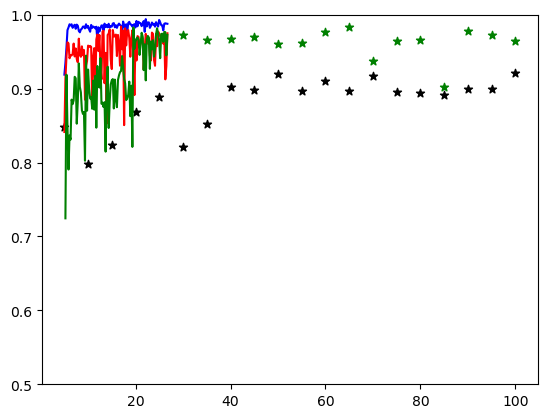

In [ ]:
import matplotlib.pyplot as plt
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(0,101)], [ x[1] for x in  first_log], color = "blue" )
# plt.plot([5*x for x in range(1, 21)], [ x[1] for x in  log] )
# plt.plot(np.arange(0, 101), [ x[1] for x in  second_performance_log] )
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(0,101)], [ x[1] for x in  second_log] , color = "red" )
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(1,101)], [ x[1] for x in  third_log] , color = "green" )
# plt.axhline(0.94)
# plt.scatter([ 35, 40, 50, 75, 100],[0.9274666026714148,0.9286135371053348,0.9390303120950066,0.9415833068610072,0.9481415809596864], color = "red" , marker = "*" )
plt.scatter(train_fractions*100,  [0.9728, 0.9662, 0.9671, 0.9701, 0.9610, 0.9616, 0.9765, 0.9833, 0.9368, 0.9647, 0.9661, 0.9023, 0.9776, 0.9726, 0.9647] , marker = "*" , color = "green")

catx = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]
catr2 = [0.8485,0.7977,0.8232,0.8679,0.8881,0.8207,0.8525,0.9018,0.8979,0.9201,0.8962,0.9099,0.8961,0.9166,0.8959,0.8942,0.8908,0.8992,0.8988,0.9215]
plt.scatter([x* 100 for x in catx] , catr2, marker = "*", color = "black")
plt.ylim(0.5,1)

# 25 % Initial Test MSE: 0.24229746295191884, R2: 0.8516043708914969
# 35 % Initial Test MSE: 0.11843110378372088, R2: 0.9274666026714148
# 40 % Initial Test MSE: 0.11655841181037568, R2: 0.9286135371053348
# 50%  Initial Test MSE: 0.09955010659747054, R2: 0.9390303120950066
# 75 % Initial Test MSE: 0.0953816269835651, R2: 0.9415833068610072
# 100% Initial Test MSE: 0.08467340609458346, R2: 0.9481415809596864


(0.8, 1.0)

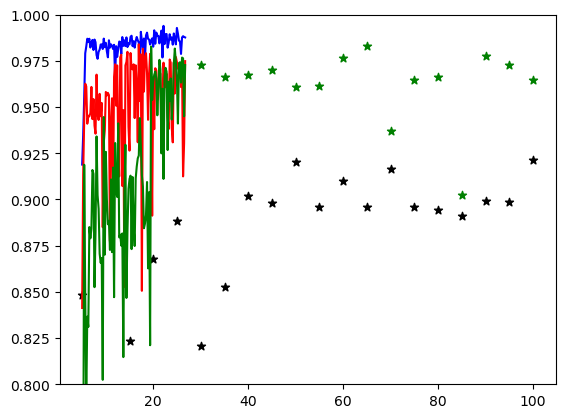

In [ ]:
import matplotlib.pyplot as plt
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(0,101)], [ x[1] for x in  first_log], color = "blue" )
# plt.plot([5*x for x in range(1, 21)], [ x[1] for x in  log] )
# plt.plot(np.arange(0, 101), [ x[1] for x in  second_performance_log] )
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(0,101)], [ x[1] for x in  second_log] , color = "red" )
plt.plot([ (10* x + int(len(X_train) * 0.05)) * 100/ len(X_train) for x in range(1,101)], [ x[1] for x in  third_log] , color = "green" )
# plt.axhline(0.94)
# plt.scatter([ 35, 40, 50, 75, 100],[0.9274666026714148,0.9286135371053348,0.9390303120950066,0.9415833068610072,0.9481415809596864], color = "red" , marker = "*" )
plt.scatter(train_fractions*100,  [0.9728, 0.9662, 0.9671, 0.9701, 0.9610, 0.9616, 0.9765, 0.9833, 0.9368, 0.9647, 0.9661, 0.9023, 0.9776, 0.9726, 0.9647] , marker = "*" , color = "green")

catx = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00]
catr2 = [0.8485,0.7977,0.8232,0.8679,0.8881,0.8207,0.8525,0.9018,0.8979,0.9201,0.8962,0.9099,0.8961,0.9166,0.8959,0.8942,0.8908,0.8992,0.8988,0.9215]
plt.scatter([x* 100 for x in catx] , catr2, marker = "*", color = "black")
plt.ylim(0.8,1)

# 25 % Initial Test MSE: 0.24229746295191884, R2: 0.8516043708914969
# 35 % Initial Test MSE: 0.11843110378372088, R2: 0.9274666026714148
# 40 % Initial Test MSE: 0.11655841181037568, R2: 0.9286135371053348
# 50%  Initial Test MSE: 0.09955010659747054, R2: 0.9390303120950066
# 75 % Initial Test MSE: 0.0953816269835651, R2: 0.9415833068610072
# 100% Initial Test MSE: 0.08467340609458346, R2: 0.9481415809596864


* 확대

(0.8, 1.0)

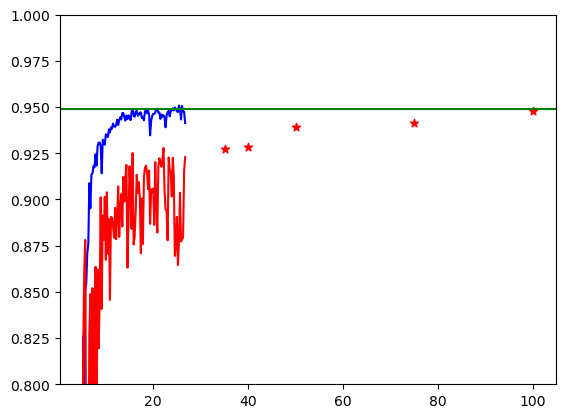

In [ ]:
plt.plot([ (10* x + int(len(X_train_scaled) * 0.05)) * 100/ len(X_train_scaled) for x in range(0,101)], [ x[1] for x in  first_performance_log], color = "blue" )
# plt.plot([5*x for x in range(1, 21)], [ x[1] for x in  log] )
# plt.plot(np.arange(0, 101), [ x[1] for x in  second_performance_log] )
plt.plot([ (10* x + int(len(X_train_scaled) * 0.05)) * 100/ len(X_train_scaled) for x in range(0,101)], [ x[1] for x in  second_performance_log] , color = "red" )
# plt.axhline(0.94)
plt.scatter([ 35, 40, 50, 75, 100],[0.9274666026714148,0.9286135371053348,0.9390303120950066,0.9415833068610072,0.9481415809596864], color = "red" , marker = "*" )

plt.axhline(y  =max( [ x[1] for x in  first_performance_log]) - 0.002, color = 'green')
# 25 % Initial Test MSE: 0.24229746295191884, R2: 0.8516043708914969
# 35 % Initial Test MSE: 0.11843110378372088, R2: 0.9274666026714148
# 40 % Initial Test MSE: 0.11655841181037568, R2: 0.9286135371053348
# 50%  Initial Test MSE: 0.09955010659747054, R2: 0.9390303120950066
# 75 % Initial Test MSE: 0.0953816269835651, R2: 0.9415833068610072
# 100% Initial Test MSE: 0.08467340609458346, R2: 0.9481415809596864
plt.ylim(0.80, 1)